In [1]:
#Questions
# - dense layer?
# - model doing better with less layers?
# - tuning layers
# - construct a class to test model differences
# - visualize model flow?
# - visualize filter outputs?
# - modeling doing better during validation than training?

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
import time
import random

import tensorflow as tf
from keras.datasets import mnist, fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

Using TensorFlow backend.


### Data Exploration

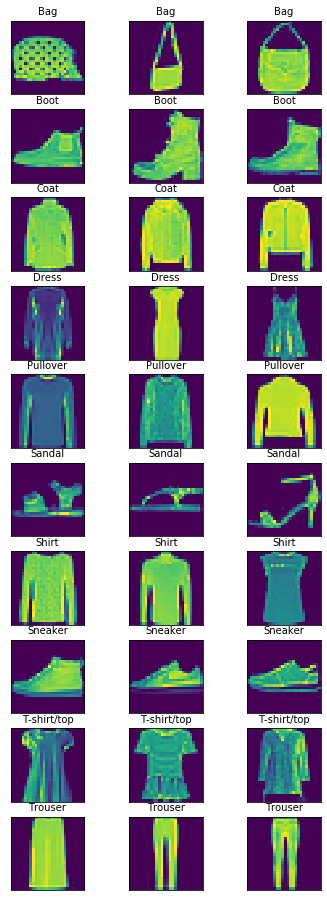

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

categories = {0: 'T-shirt/top',
             1: 'Trouser',
             2: 'Pullover',
             3: 'Dress',
             4: 'Coat',
             5: 'Sandal',
             6: 'Shirt',
             7: 'Sneaker',
             8: 'Bag',
             9: 'Boot'}

#plot sample of categories
test = list(zip(x_train, [categories[x] for x in y_train]))
test_df = pd.DataFrame(test)

function = lambda obj: obj.loc[np.random.choice(obj.index, 3, False)]
grouped = test_df.groupby(1).apply(function)

fig, axes = plt.subplots(10,3, figsize = (6,16))
axes = axes.flatten()
for i, image in enumerate(grouped[0]):
    axes[i].imshow(image)
    axes[i].set_title(grouped[1][i], size=10)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

### Data Processing and CNN

In [4]:
#scaling to ease computational burden of model
#note: scaling does not change the way the image renders
x_train_scaled = x_train/255
x_test_scaled = x_test/255

#convert to float 32 to use less space, float64 uses twice as much memory
x_train_scaled_32 = x_train_scaled.astype('float32')
x_test_scaled_32 = x_test_scaled.astype('float32')

#reshape to 4d array with expected input shape of (batch, rows, columns, channels)
x_train_scaled_shape = x_train_scaled_32.reshape(x_train_scaled_32.shape[0], 28, 28, 1)
x_test_scaled_shape = x_test_scaled_32.reshape(x_test_scaled_32.shape[0], 28, 28, 1)

#convert labels to one-hot-encoded arrays
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

In [120]:
def create_params(values_dict: dict) -> list:
    """Create list of dictionaries for every combination of kernel / filter values indicated"""
    (key1, val1), (key2, val2) = values_dict.items()
    return [{key1: x, key2: y} for x in val1 for y in val2]

class CNN:
    """Creates a CNN object, which has methods create_model (to create CNN model) 
    and fit_model (to evaluate and record model results)"""
    def __init__(self, params_dict):
        self.params = params_dict
        self.kernels = params_dict['kernels']
        self.filters = params_dict['filters']
        self.model = self.create_model()

#     def fit_model(self, epochs=3, batch_size=100):
#         kernels = self.kernels
#         filters = self.filters
#         model = Sequential([Conv2D(filters=filters, kernel_size=kernels, activation='relu',input_shape=x_train_scaled_shape.shape[1:]),
#                             Flatten(),
#                             Dense(10, activation='softmax')])
#         start_time = time.time()
#         model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
#         end_time = time.time()
#         model_time = end_time - start_time
#         model_output=model.fit(x_train_scaled_shape, y_train_cat, batch_size=batch_size, epochs=epochs, verbose=1, 
#                          shuffle=True, validation_split=0.2)
#         history = pd.DataFrame(model_output.history)
#         history['epoch'] = list(range(1, epochs+1))
#         history['model_time'] = model_time
#         history['filters'] = filters
#         history['kernel_size'] = str(kernels)
#         return history
    
    def create_model(self):
        kernels = self.kernels
        filters = self.filters
        model = Sequential([Conv2D(filters=filters, kernel_size=kernels, activation='relu',input_shape=x_train_scaled_shape.shape[1:]),
                            Flatten(),
                            Dense(10, activation='softmax')])
        return model
        
    def fit_model(self, model, epochs=3, batch_size=100):
        start_time = time.time()
        kernels = self.kernels
        filters = self.filters
        model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
        datagen = ImageDataGenerator(rotation_range=10,
                                zoom_range=0.1,
                                width_shift_range=0.1,
                                height_shift_range=0.1)
    
        model_output = model.fit_generator(datagen.flow(x_train_scaled_shape, y_train_cat, batch_size=batch_size), epochs=epochs,
                                 validation_data=(x_test_scaled_shape, y_test_cat), steps_per_epoch=x_train_scaled_shape.shape[0]/batch_size)
        end_time = time.time()
        model_time = end_time - start_time
        history = pd.DataFrame(model_output.history)
        history['epoch'] = list(range(1, epochs+1))
        history['model_time'] = model_time
        history['filters'] = filters
        history['kernel_size'] = str(kernels)
        return history

In [88]:
testdict = {'kernels':[(5,5),(10,10),(15,15),(28,28)], 'filters':[5,10,30,60]}
params_list = create_params(testdict)

all_results = pd.DataFrame()
for param in params_list:
    cnn = CNN(param)
    model = cnn.create_model()
    model_results = cnn.fit_model(model, epochs=3, batch_size=100)
    all_results = all_results.append(model_results)
    
all_results.head()

Epoch 1/3
600/600 [==============================] - 15s 25ms/step - loss: 0.8130 - accuracy: 0.7056 - val_loss: 0.6099 - val_accuracy: 0.7710
Epoch 2/3
600/600 [==============================] - 15s 25ms/step - loss: 0.6481 - accuracy: 0.7599 - val_loss: 0.5555 - val_accuracy: 0.7973
Epoch 3/3
600/600 [==============================] - 15s 25ms/step - loss: 0.6067 - accuracy: 0.7779 - val_loss: 0.5178 - val_accuracy: 0.8156
Epoch 1/3
600/600 [==============================] - 15s 24ms/step - loss: 0.7879 - accuracy: 0.7116 - val_loss: 0.5695 - val_accuracy: 0.7814
Epoch 2/3
600/600 [==============================] - 14s 23ms/step - loss: 0.6219 - accuracy: 0.7718 - val_loss: 0.5513 - val_accuracy: 0.7969
Epoch 3/3
276/600 [============>.................] - ETA: 7s - loss: 0.5774 - accuracy: 0.7864

KeyboardInterrupt: 

In [68]:
max_acc = all_results['accuracy'].max()
all_results[all_results['accuracy'] == max_acc]
all_results.sort_values('accuracy',ascending=False)

,val_loss,val_accuracy,loss,accuracy,epoch,model_time,filters,kernel_size
2,0.303447,0.894417,0.283757,0.899188,3,0.026283,60,"(5, 5)"
2,0.310595,0.889750,0.292294,0.895729,3,0.025633,30,"(5, 5)"
2,0.328581,0.885083,0.315589,0.887417,3,0.028257,60,"(10, 10)"
1,0.327009,0.884833,0.324931,0.884687,2,0.026283,60,"(5, 5)"
1,0.327396,0.886083,0.334758,0.883417,2,0.025633,30,"(5, 5)"
2,0.335388,0.882000,0.329239,0.881437,3,0.027659,30,"(10, 10)"
2,0.353069,0.873500,0.348325,0.877375,3,0.083074,10,"(5, 5)"
2,0.354378,0.873000,0.349523,0.875313,3,0.026022,60,"(15, 15)"
2,0.359077,0.872833,0.360530,0.874229,3,0.037478,5,"(5, 5)"
1,0.360614,0.870333,0.357706,0.872354,2,0.028257,60,"(10, 10)"


ValueError: Could not interpret input 'epoch'

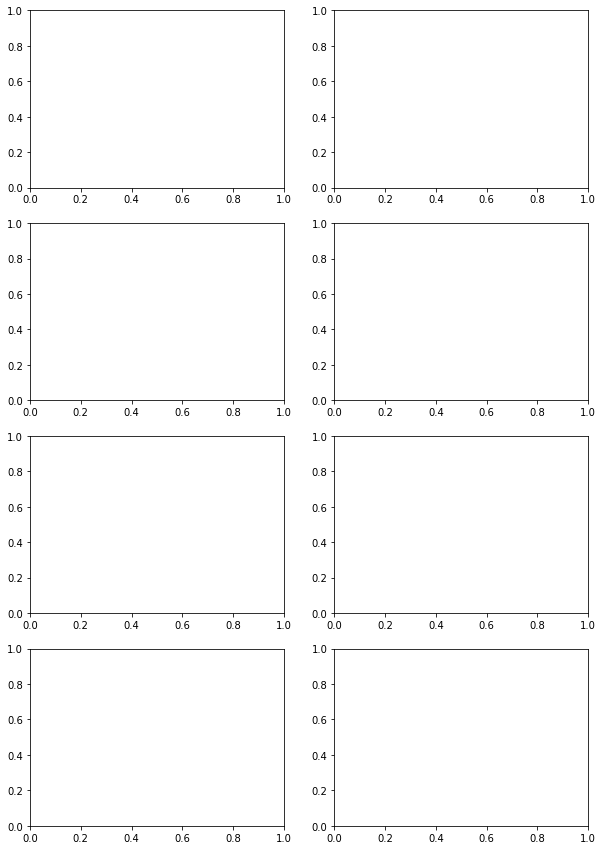

In [86]:
#visualize effects of different parameters on model results and training time
fig, axes = plt.subplots(4,2,figsize=(10,15))
axes = axes.flatten()
for i, metric in enumerate(['filters','kernel_size']):
    sns.lineplot('epoch','accuracy',data=all_results, hue=metric, ax=axes[i*4])
    axes[i*3].set_title('Effect of '+metric+' on Accuracy',size=13)
    sns.lineplot('epoch','loss',data=all_results, hue=metric, ax=axes[i*4+1])
    axes[i*3+1].set_title('Effect of '+metric+' on Loss',size=13)
    sns.barplot('epoch','model_time',data=all_results, hue=metric, ax=axes[i*4+2])
    axes[i*3+2].set_title('Effect of '+metric+' on Model Time',size=13)
    sns.lineplot('epoch','accuracy',data=all_results,ax=axes[i*4+3], label='training')
    sns.lineplot('epoch','val_accuracy',data=all_results,ax=axes[i*4+3], label='validation')
    axes[i*4+3].legend()
    axes[i*4+3].set_title('Training vs. Validation Accuracy')
    plt.tight_layout()

### Prediction analysis

In [228]:
#find best model
#best_model = all_results[all_results['accuracy']==all_results['accuracy'].max()]
best_params = {'kernel_size':(3,3), 'filters':60}
best_model = CNN(best_params)
prediction_model = best_model.create_model()
history = best_model.fit_model(prediction_model)

#calculate predictions
predictions = prediction_model.predict(x_test_scaled_shape)
predicted = [np.argmax(x) for x in predictions]
counter = Counter()
for x,y in list(zip(predicted, y_test)):
    if x==y:
        counter[y]+=1
counter

KeyError: 'kernels'

In [226]:
pred_df = pd.DataFrame(zip(predicted, y_test)).rename(columns={0:'predicted',1:'actual'})
pred_df['predicted_label'] = pred_df['predicted'].map(categories)
pred_df['actual_label'] = pred_df['actual'].map(categories)
pred_df['correct'] = pred_df['actual'] == pred_df['predicted']
correct = pred_df.groupby('actual_label')[['correct']].sum().sort_values('correct', ascending=False)
display(correct)

wrong = pred_df[pred_df['correct']==False].groupby(['actual_label','predicted_label'])[['correct']].count().sort_values('correct',ascending=False)
top5_wrong = wrong.nlargest(10, 'correct')
display(wrong)

,correct
actual_label,
Boot,False
Pullover,False
Trouser,False


,,correct
actual_label,predicted_label,


ValueError: min() arg is an empty sequence

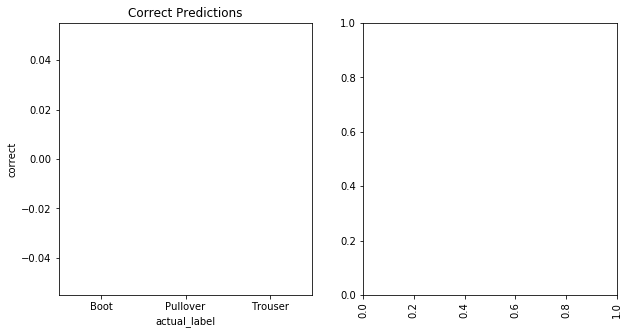

In [225]:
fig, axes = plt.subplots(1,2, figsize=(10, 5))
sns.barplot(correct.index, correct['correct'], ax=axes[0], palette='mako_r')
axes[0].set_title('Correct Predictions')
plt.xticks(rotation='vertical')
sns.barplot(top5_wrong.index, top5_wrong['correct'], ax=axes[1], palette='mako_r')
axes[1].set_title('Top Incorrect Categories')
plt.tight_layout()
plt.xticks(rotation='vertical')

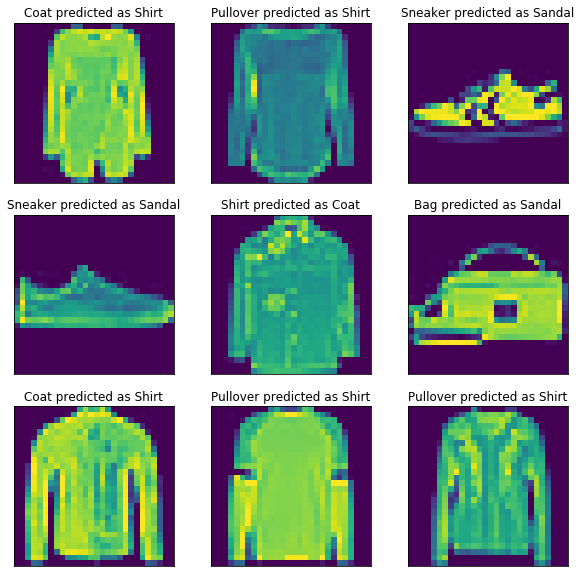

In [221]:
#closer look at shirts, most incorrectly predicted label
#something is very wrong with these labels lol
incorrect = pred_df[pred_df['actual_label']!=pred_df['predicted_label']]
incorrect_indices = incorrect.index

sampling_incorrect = random.choices(incorrect_indices, k=9)
fig, axes = plt.subplots(3,3,figsize=(10,10))
axes = axes.flatten()

for i,index in enumerate(sampling_incorrect):
    actual_label = pred_df.iloc[index]['actual_label']
    predicted_label = pred_df.iloc[index]['predicted_label']
    axes[i].imshow(x_test_scaled[index])
    axes[i].set_title(actual_label +' predicted as '+predicted_label, size=12)
    axes[i].grid(False)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

In [227]:
#save and load a model
model.save('mnist_fashion.model')
new_model = tf.keras.models.load_model('mnist_fashion.model')